In [180]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

## Zadanie 1

In [181]:
def RTable(img, threshold):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, bin = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    bin = cv2.morphologyEx(bin, cv2.MORPH_CLOSE, np.ones((3,3)))
    bin = ~bin.astype(np.uint8)
    plt.imshow(bin, cmap='gray')
    plt.show()

    contours, hierarchy = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    plt.imshow(cv2.drawContours(img, contours , -1, (255,0,0) ))
    plt.show()

    sobelx = cv2.Sobel(bin, cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(bin,cv2.CV_64F,0,1,ksize=5)
    sobelx = sobelx/np.amax(sobelx)
    sobely = sobely/np.amax(sobely)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    gradient = gradient/np.amax(gradient)
    plt.imshow(sobelx.astype(np.float32))
    plt.show()
    plt.imshow(sobely.astype(np.float32))
    plt.show()
    plt.imshow(gradient.astype(np.float32))
    plt.show()
    alpha = np.arctan2(sobelx,sobely)
    plt.imshow(alpha.astype(np.float32))
    plt.show()

    moments_img = cv2.moments(bin, 1)
    RTable = [[] for _ in range (360) ]
    xc, yc = (moments_img['m01']/moments_img['m00'], moments_img['m10']/moments_img['m00'] )
    for i in range(contours[0].shape[0]):
        (x,y) = contours[0][i,0,:]
        alpha_t = -np.arctan2(xc-x,yc-y)+np.pi/2
        norm = np.sqrt((xc-x)**2+(yc-y)**2)
        theta = round(alpha[x,y]*360/(2*np.pi)+90)
        RTable[theta].append((norm,alpha_t))
    
    return RTable, contours, xc, yc, gradient


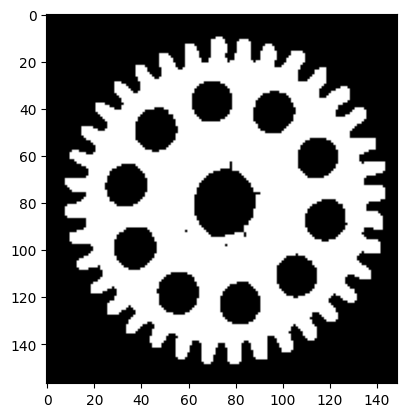

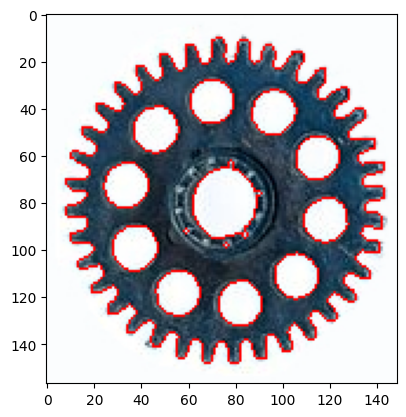

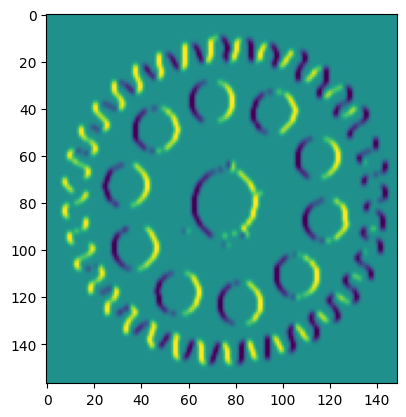

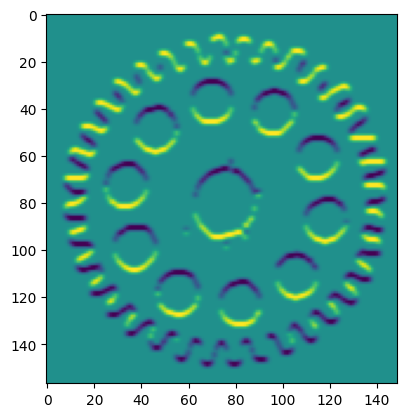

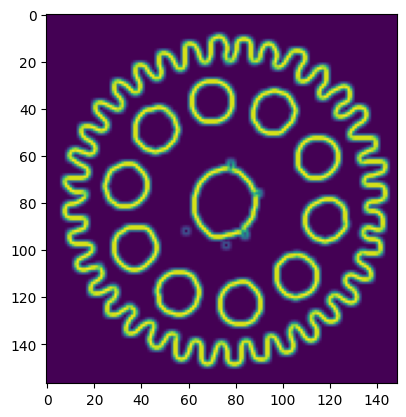

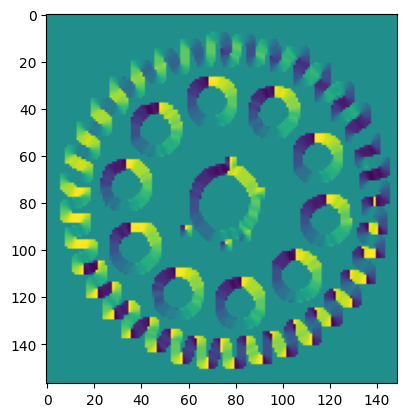

In [182]:
trybik = cv2.imread('trybik.jpg')
table, contours, xc, yc, gradient = RTable(trybik, 225)

In [183]:
def find(img, threshold, rtable, contours, xc, yc, gradient):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    th, bin = cv2.threshold(img_gray, threshold, 255 , cv2.THRESH_BINARY)
    bin = ~bin
    bin = cv2.morphologyEx(bin, cv2.MORPH_CLOSE, np.ones((3,3)))
    plt.imshow(bin, cmap='gray')
    plt.show()

    hough = np.zeros(np.array(bin.shape)+40)
    sobelx = cv2.Sobel(bin, cv2 . CV_64F ,1 ,0 , ksize =5)
    sobely = cv2 . Sobel (bin, cv2 . CV_64F ,0 ,1 , ksize =5)
    sobelx = sobelx/np.amax(sobelx)
    sobely = sobely/np.amax(sobely)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    gradient = gradient/np.amax(gradient)
    alpha = np.arctan2(sobelx,sobely)
    plt.imshow(alpha.astype(np.float32))
    plt.show()

    for i in range(gradient.shape[0]):
        for j in range(gradient.shape[1]):
            if(gradient[i,j]>0.5):
                fi = alpha[i,j]
                for pair in rtable[round(fi*360/(2*np.pi)+90)]:
                    (r, alp) = pair
                    x1 = round(r* np . cos ( alp ) + i) #+ img_.shape[0]//2
                    y1 = round(r* np . sin ( alp ) + j) #+ img_.shape[1]//2
                    hough[x1,y1] += 1
    plt.imshow(6*hough.astype(np.float32)/np.max(hough.astype(np.float32)),cmap='gray')
    plt.show()

    # [ m_x ], [ m_y ] = np . where ( hough . max () == hough )
    temp = list(contours[0].shape)
    temp.insert(0, 1)
    # contour_temp = tuple((np.array(contours)-np.array([xc, yc])+np.array([m_x,m_y])))

    plt.imshow(img)
    delta = 80
    max_lst = []
    hough = cv2.GaussianBlur(hough, (5,5), 0)
    for max in range(0, 5):
        temp = np.unravel_index(np.argmax(hough), hough.shape)
        max_lst.append(temp)
        hough[temp[0]-delta:temp[0]+delta, temp[1]-delta:temp[1]+delta] = 0
        plt . plot ([ temp[1] ], [ temp[0] ] ,'*', color ='r')

    plt.imshow(img)
    for (x,y) in max_lst:
        cnt = deepcopy(np.array(contours,dtype=np.ndarray))
        for i in range(cnt.shape[0]):
            for j in range(cnt[i].shape[0]):
                for k in range(cnt[i].shape[1]):
                    cnt[i][j,k,:] -= np.array([yc, xc],dtype=np.int32)-np.array([y,x],dtype=np.int32)

        cv2.drawContours( img, cnt , -1, (255,0,0) )
        plt . plot ([ y ], [ x ] ,'*', color ='r')
    plt.imshow(img)

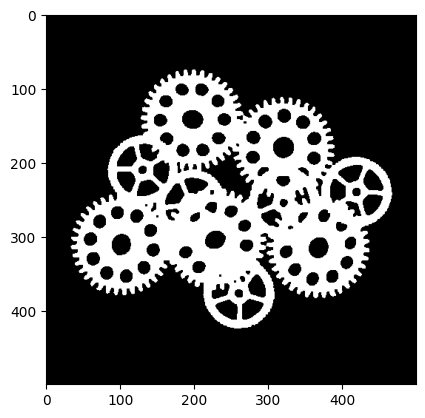

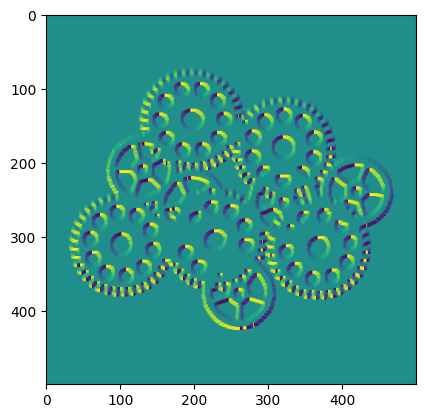

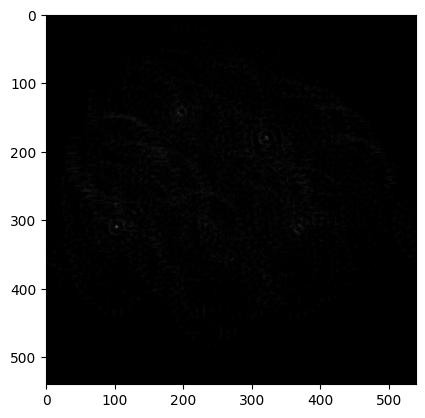

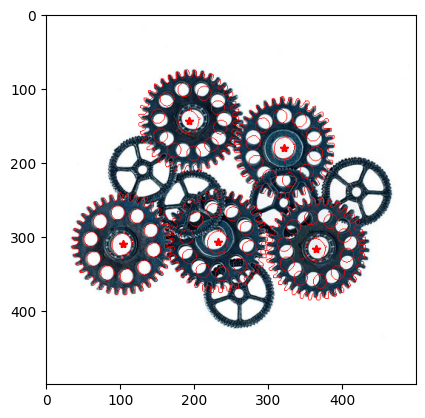

In [184]:
img = cv2.imread("trybiki2.jpg")
find(img, 215, table, contours, xc, yc, gradient)

## Task 2

In [ ]:
import numpy as np
import cv2

def compute_r_table(template_image, angle_step=10):
    """
    Tworzy R-table na podstawie wzorca:
    - automatycznie wykrywa największy kontur
    - centroid konturu jako punkt odniesienia
    - oblicza krawędzie, orientację i uzupełnia R-table

    Arguments:
    - template_image: obraz wzorca (w skali szarości)
    - angle_step: dyskretyzacja kąta w stopniach (domyślnie 10)

    Returns:
    - r_table: słownik {kąt (w stopniach): lista [(r, fi)]}
    """
    # Wyznaczanie krawędzi
    edges = cv2.Canny(template_image, 100, 200)

    # Wyszukiwanie konturów
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("Nie znaleziono konturów na obrazie wzorca")

    # Wybierz największy kontur
    contour = max(contours, key=cv2.contourArea)

    # Oblicz centroid konturu
    M = cv2.moments(contour)
    if M["m00"] == 0:
        raise ValueError("Nie można obliczyć środka ciężkości konturu")
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    # Obliczanie gradientu i orientacji
    dx = cv2.Sobel(template_image, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(template_image, cv2.CV_64F, 0, 1, ksize=3)
    orientations = np.arctan2(dy, dx)  # w radianach

    # Inicjalizacja R-table
    r_table = {}

    for point in contour:
        x, y = point[0]
        angle = orientations[y, x]
        deg_angle = int(np.rad2deg(angle)) % 360
        deg_angle = (deg_angle // angle_step) * angle_step

        dx = cx - x
        dy = cy - y
        r = np.hypot(dx, dy)
        fi = np.arctan2(dy, dx)

        if deg_angle not in r_table:
            r_table[deg_angle] = []
        r_table[deg_angle].append((r, fi))

    return r_table


In [199]:
def find_2(img, threshold, rtable, contours, xc, yc, angle_bins=36):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, bin_img = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))

    hough_shape = bin_img.shape + (angle_bins,)
    hough = np.zeros(hough_shape, dtype=np.float32)

    sobelx = cv2.Sobel(bin_img, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(bin_img, cv2.CV_64F, 0, 1, ksize=5)
    gradient = np.hypot(sobelx, sobely)
    gradient /= np.max(gradient)
    alpha = np.arctan2(sobely, sobelx)

    for y in range(bin_img.shape[0]):
        for x in range(bin_img.shape[1]):
            if gradient[y, x] > 0.25:
                alpha_deg = (np.degrees(alpha[y, x]) + 90) % 360

                for d in range(angle_bins):
                    d_alpha_deg = d * 360 / angle_bins
                    alpha_n = (alpha_deg - d_alpha_deg) % 360
                    bin_idx = int(alpha_n / 360 * angle_bins) % angle_bins
                    df_rad = np.deg2rad(d_alpha_deg)

                    for r, phi in rtable[bin_idx]:
                        x0 = int(round(x - r * np.cos(phi + df_rad)))
                        y0 = int(round(y - r * np.sin(phi + df_rad)))
                        if 0 <= x0 < bin_img.shape[1] and 0 <= y0 < bin_img.shape[0]:
                            hough[y0, x0, d] += 1

    maxima = []
    delta = 30
    for _ in range(5):
        idx = np.argmax(hough)
        m = np.unravel_index(idx, hough.shape)
        maxima.append(m)
        y0, x0, _ = m
        hough[max(0, y0 - delta):y0 + delta, max(0, x0 - delta):x0 + delta, :] = 0

    # Rysowanie znalezionych punktów
    plt.imshow(img)
    for (y0, x0, _) in maxima:
        plt.plot(x0, y0, '*', color='red')
    plt.title("Znalezione obiekty")
    plt.show()

    # Rysowanie wzorca w znalezionych lokalizacjach
    img_with_contours = img.copy()
    for (y0, x0, angle_idx) in maxima:
        df_rad = 2 * np.pi * angle_idx / angle_bins
        cnt = [c.copy() for c in contours]
        for i in range(len(cnt)):
            for j in range(len(cnt[i])):
                pt = cnt[i][j][0].astype(np.float32)
                pt_centered = pt - np.array([xc, yc], dtype=np.float32)
                rot_x = pt_centered[0] * np.cos(df_rad) - pt_centered[1] * np.sin(df_rad)
                rot_y = pt_centered[0] * np.sin(df_rad) + pt_centered[1] * np.cos(df_rad)
                cnt[i][j][0] = np.array([rot_x + x0, rot_y + y0], dtype=np.int32)

        cv2.drawContours(img_with_contours, cnt, -1, (255, 0, 0), 1)

    plt.imshow(img_with_contours)
    plt.title("Dopasowane kontury")
    plt.show()


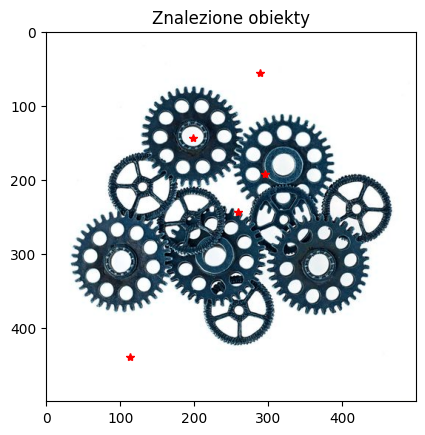

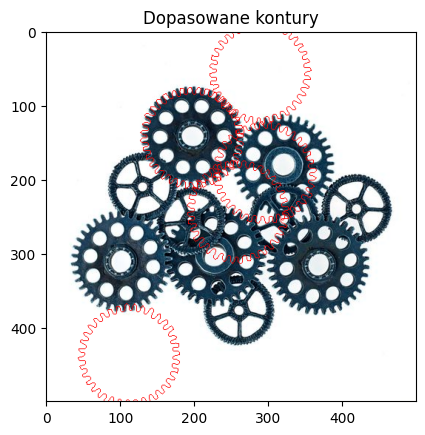

In [201]:
trybik2 = cv2.imread('trybik.jpg')
table2, contours2, xc2, yc2 = RTable_2(trybik2, 230)

img2 = cv2.imread("trybiki2.jpg")
find_2(img2, 230, table2, contours2, xc2, yc2)